# About this Notebook

The purpose of this notebook is to bring a first approach on the magnetic compensation of the carrier. In a first step, we realize a phase of exploration with the trajectory of the flights and the location of the different sections as well as some general information on the dataset. We will also see the different magnetic cards available and their differences.<br> 
We will also see the position of the diferent sensors in the plane to have an idea of their coverage. An animation is available to visualize the direction of the magnetic field measured by the vector magnetometers during the flight. An exploitation of the events during the flight is also realized to try to show a relation between the magnetic measurements and the different elements of the plane.<br>
A first correction of the data will then be realized by showing the impact of these corrections. Then comes a last step of selection of the features for our model as well as some precautions to take with regard to the data available for training.

# Table of contents

* [0 - Dataset general informations](#0)
* [1 - Select a flight](#1)
    * [1.1 - Flight number](#1.1)
    * [1.2 - Flight section](#1.2)
* [2 - Map view](#2)
    * [2.1 - OpenStreetMap](#2.1)
    * [2.2 - Magnetic anomaly maps](#2.2)
        * [2.2.1 - What's a magnetic anomaly map ?](#2.2.1)
        * [2.2.2 - Canada map](#2.2.2)
        * [2.2.3 - Challenge maps](#2.2.3)
        * [2.2.4 - World Magnetic Anomaly Map](#2.2.4)
        * [2.2.5 - Map resolutions](#2.2.5)
* [3 - Flight events](#3)
    * [3.1 - Events during the selected section(s)](#3.1)
    * [3.2 - Label creation for different events](#3.2)
* [4 - Visualization of magnetic sensors position and direction](#4)

# Setup

In [1]:
import os
# Move from notebooks to MagNav
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

A:\Documents\GitHub\MagNav\notebooks
A:\Documents\GitHub\MagNav


# Import packages

In [2]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import image
from ipyleaflet import Map, LocalTileLayer, Polyline, LegendControl, ScaleControl
from scipy import signal

import src.magnav as magnav

# 0 - Dataset general informations <a class="anchor" id = "0"></a>

This dataset has 4 different flights :
- 1002 - Flight at 3000 meters of altitude. It includes the calibration flights as well as different elements aiming at disturbung the virtual dipole of the place
- 1003 - Flight at 400/800 meters of altitude. The goal of this flight was to collect free flight data over several hours.
- 1004 - Flight at 800 meters of altitude over Eastern free flight area. The goal of this flight is to create a high resolution map of the area.
- 1005 - Same as flight 1004 with a higher altitude. Due to weather concern, data collection was split in 2.

Each flight contains lines that are intended to segment the flight into different parts. We have a lot of differents measurements including magnetometers. Truth data here is __"IGRFMAG1"__, the magnetometer 1 at tail stinger compensated by SGL (Geological Survey company).

In [3]:
# Import dataset
flights_num = [2,3,4,5,6,7]
flights = {}

for n in flights_num:
    df = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt100{n}')
    flights[n] = df

# Extract sampling frequency, duration and number of data collected from the dataset
for n in flights_num:
    
    lines = flights[n].LINE.unique()

    total_duration  = 0
    total_data      = 0
    total_freq_samp = 0

    for l in lines :
        df_lines = pd.DataFrame()
        mask     = (flights[n].LINE == l)
        df_lines = pd.concat([df_lines,flights[n].loc[mask]],axis=0)

        freq_samp = magnav.sampling_frequency(df_lines)
        nb_data   = np.shape(df_lines)[0]
        duration = nb_data*(1/freq_samp)

        total_duration  += duration
        total_data      += np.shape(df_lines)[0]
        total_freq_samp += freq_samp/len(lines)
        total_lines      = len(lines)

    
    print(f'Flight : 100{n} | Total flight time : {magnav.to_hms(total_duration)} | Number of data collected : {total_data} | Sampling frequency : {total_freq_samp:.2f}Hz | Number of unique flight lines : {total_lines}')
    
del df,lines,df_lines,mask

Flight : 1002 | Total flight time : 05h:45m:55s | Number of data collected : 207578 | Sampling frequency : 10.00Hz | Number of unique flight lines : 28
Flight : 1003 | Total flight time : 04h:26m:42s | Number of data collected : 160030 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10
Flight : 1004 | Total flight time : 02h:15m:38s | Number of data collected : 81408 | Sampling frequency : 10.00Hz | Number of unique flight lines : 21
Flight : 1005 | Total flight time : 02h:16m:12s | Number of data collected : 81731 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10
Flight : 1006 | Total flight time : 03h:00m:31s | Number of data collected : 108318 | Sampling frequency : 10.00Hz | Number of unique flight lines : 8
Flight : 1007 | Total flight time : 03h:10m:50s | Number of data collected : 114506 | Sampling frequency : 10.00Hz | Number of unique flight lines : 6


<font size="4">Interpretation of results :</font><br>
All flights are at the same frequency, flight 1003 is the longest with the most data.

# 1 - Select a flight <a class="anchor" id = "1"></a>

To better understand the data, it is important to first visualize the trajectories. In the following cells, we can select the flight we are interested in and sections of the flight.

## 1.1 - Flight number <a class="anchor" id = "1.1"></a>

In [4]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5), ('1006', 6), ('1007', 7)],
    value=7,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=5, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5),…

In [5]:
df_sel_flight = flights[w_flight.value].copy()

## 1.2 - Flight section <a class="anchor" id = "1.2"></a>

In [6]:
# Create a widget to select the line(s) of the selected flight

w_lines = widgets.SelectMultiple(
    options     = df_sel_flight.LINE.unique(),
    description = 'Select line(s):',
    disabled    = False)
display(w_lines)

SelectMultiple(description='Select line(s):', options=(1007.01, 1007.02, 1007.03, 1007.05, 1007.06, 1007.07), …

In [7]:
# Extracting selected line(s) from the dataset

df_sel_lines = pd.DataFrame()
for line in w_lines.value:
    mask     = (df_sel_flight.LINE == line)
    df_sel_lines = pd.concat([df_sel_lines,df_sel_flight.loc[mask]],axis=0)

duration = np.shape(df_sel_lines)[0]*(1/freq_samp)

print(f'Rows : {np.shape(df_sel_lines)[0]} | Columns : {np.shape(df_sel_lines)[1]} | Duration : {magnav.to_hms(duration)}\n')

Rows : 114506 | Columns : 96 | Duration : 03h:10m:49s



# 2 - Map view <a class="anchor" id = "2"></a>

## 2.1 - OpenStreetMap <a class="anchor" id = "2.1"></a>

In [8]:
# Does not work when internet is off with jupyter lab
m = Map(center   = [45.1278, -75.5120],
        zoom     = 8,
        max_zoom = 12,
        min_zoom = 8,
        layout   = Layout(width='100%',height='800px'))

legend = LegendControl({},name="Legend",position="topright")
step = 10 
for line in w_lines.value:
    color = magnav.get_random_color()
    mask = (df_sel_flight.LINE == line)
    locations = (df_sel_flight
                 .loc[mask,['LAT','LONG']][::step]
                 .values
                 .tolist())
    pline = Polyline(
        locations = locations,
        color     = color,
        fill      = False,
        opacity   = 1)
    m.add_layer(pline)
    legend.add_legend_element(str(line),color)

m.add_control(legend)
m.add_control(ScaleControl(position='bottomleft'))
m

Map(center=[45.1278, -75.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

## 2.2 - Magnetic anomaly maps <a class="anchor" id = "2.2"></a>

### 2.2.1 - What's a magnetic anomaly map ? <a class="anchor" id = "2.2.1"></a>

A magnetic anomaly is a local variation in the Earth's magnetic field resulting from variations in the chemistry or magnetism of the rocks. These anomalies are then put in the form of maps and can be used as reference for navigation.<br><br>
![](../data/external/Images/WDMAM.png)

In [9]:
# Load anomaly maps
EasternMap = magnav.ChallMagMap('data/raw/Eastern_2.h5')
RenfrewMap = magnav.ChallMagMap('data/raw/Renfrew_2.h5')
GscMap     = magnav.ChallMagMap('data/external/Canada_MAG_RES_200m.hdf5')
WDMAM      = magnav.ChallMagMap('data/external/map_WDMAM.hdf5')

### 2.2.2 - Canada map <a class="anchor" id = "2.2.2"></a>

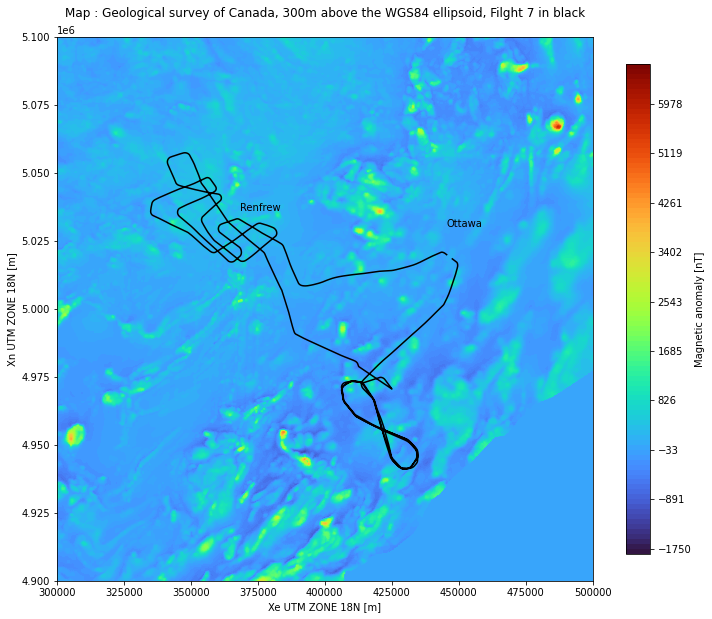

In [10]:
fig, ax = plt.subplots(figsize=[12,10])
df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = GscMap.plot(ax, plot_city=True)
ax.set_title(f'Map : Geological survey of Canada, {GscMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);
ax.set_xlim(3e5, 5e5)
ax.set_ylim(4.90e6, 5.1e6)
plt.show()

### 2.2.3 - Challenge maps <a class="anchor" id = "2.2.3"></a>

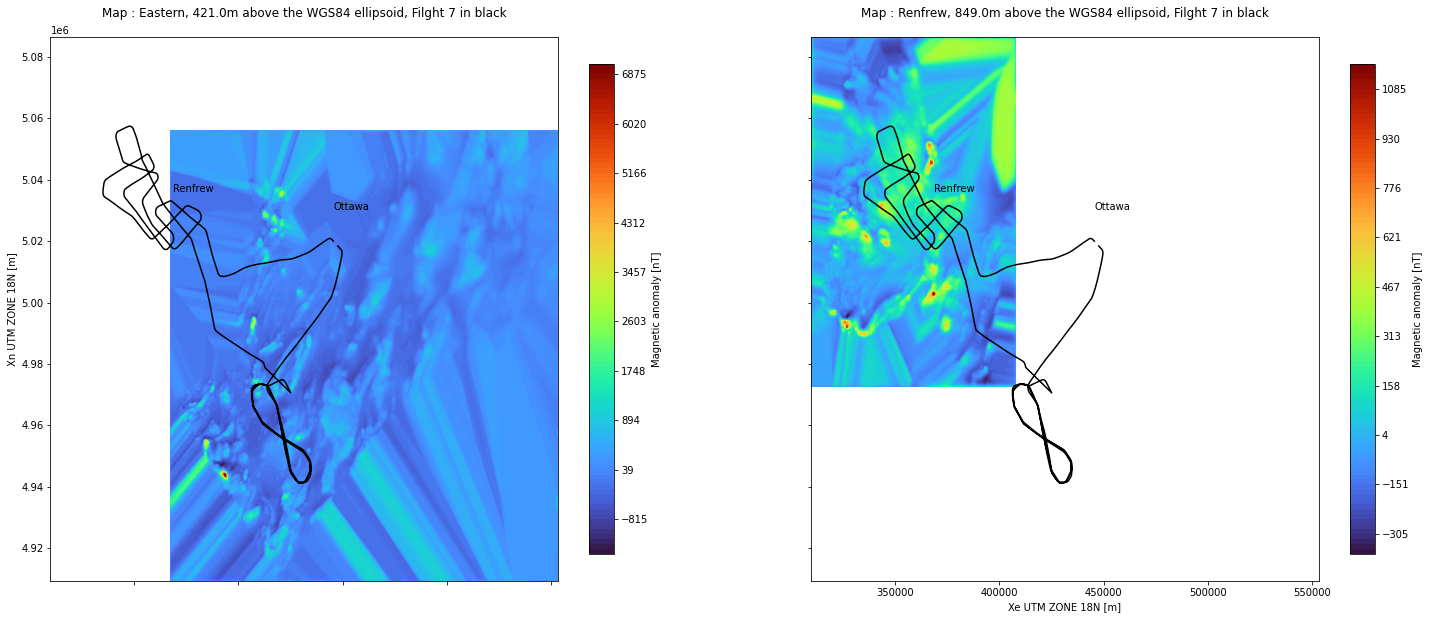

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[25,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = EasternMap.plot(ax1,plot_city=True)
ax1.set_title(f'Map : Eastern, {EasternMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = RenfrewMap.plot(ax2, plot_city=True)
ax2.set_title(f'Map : Renfrew, {RenfrewMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

### 2.2.4 - World Digital Magnetic Anomaly Map <a class="anchor" id = "2.2.4"></a>

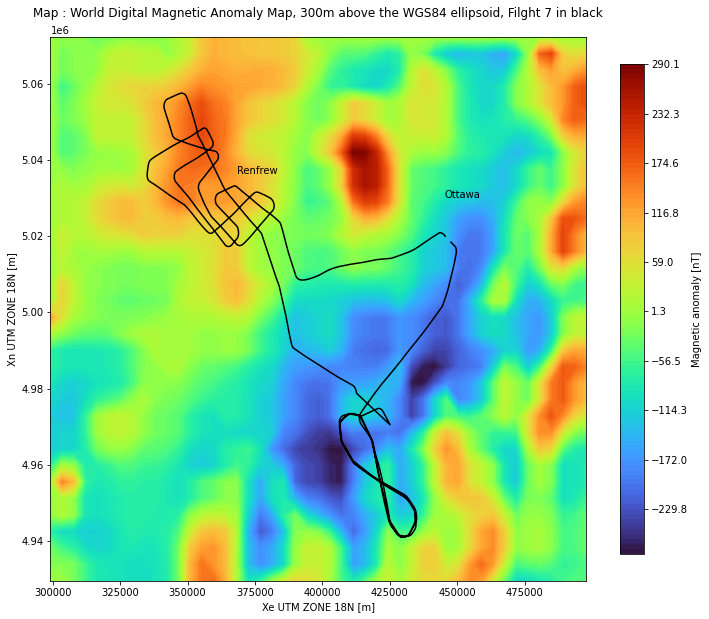

In [12]:
fig, ax = plt.subplots(figsize=[12,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = WDMAM.plot(ax, plot_city=True)
ax.set_title(f'Map : World Digital Magnetic Anomaly Map, {WDMAM.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

### 2.2.5 - Map resolutions <a class="anchor" id = "2.2.5"></a>

The goal is to compare the accuracy between anomaly maps and truth data and see the impact of map accuracy. In this dataset, we have the truth thanks to a magnetometer on a pole. However in most experiments this is not the case (same for navigation) and so the way to get truth is from magnetic anomaly maps.
We have 4 different maps available :
- Anomaly map of Canada (mid resolution)
- Anomaly map of Renfrew (high resolution)
- Anomaly map of Eastern Renfrew, south of Ottawa (high resolution)
- World Digital Magnetic Anomaly Map (low resolution)

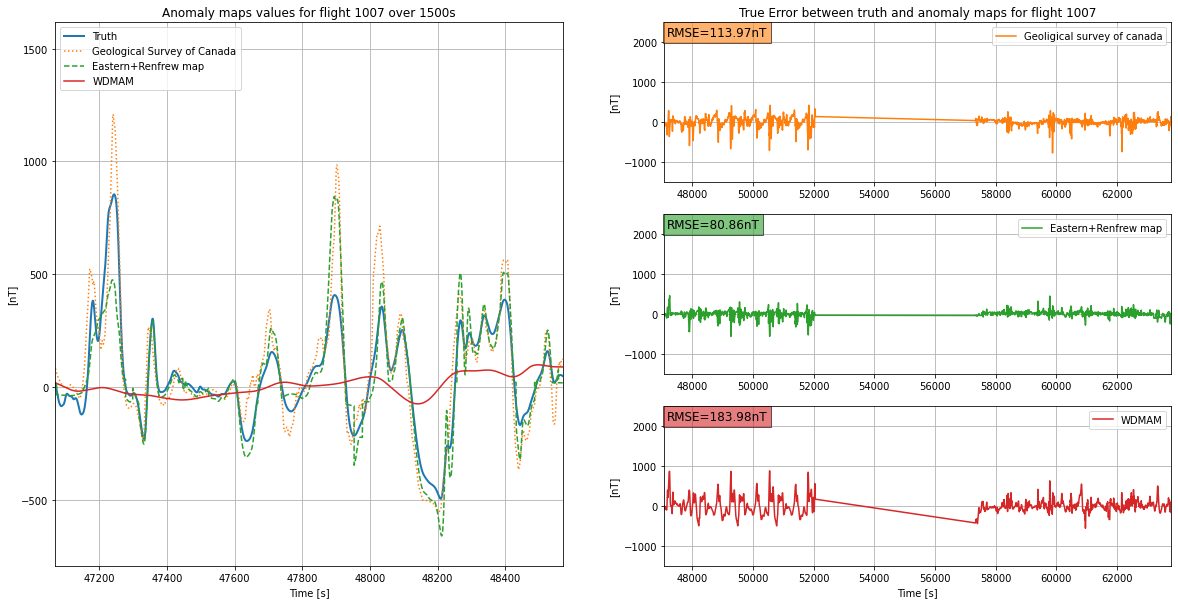

In [14]:
df_maps = pd.DataFrame()

# Interpolation of anomaly maps
df_maps['IGRFMAG1']    = df_sel_flight['IGRFMAG1'].copy()
df_maps['GSC_map']     = GscMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['Eastern_map'] = EasternMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['Renfrew_map'] = RenfrewMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['WDMAM_map']   = WDMAM.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)

# Remove linear trend
df_maps['IGRFMAG1']    = signal.detrend(df_maps['IGRFMAG1'])
df_maps['WDMAM_map']   = signal.detrend(df_maps['WDMAM_map'])
df_maps['Eastern_map'] = signal.detrend(df_maps['Eastern_map'])
df_maps['Renfrew_map'] = signal.detrend(df_maps['Renfrew_map'])
df_maps['GSC_map']     = signal.detrend(df_maps['GSC_map'])

# Calculate error between truth data and anomaly maps
GSC_map_error     = (df_maps['IGRFMAG1']-df_maps['GSC_map'])
Eastern_map_error = (df_maps['IGRFMAG1']-df_maps['Eastern_map'])
Renfrew_map_error = (df_maps['IGRFMAG1']-df_maps['Renfrew_map'])
WDMAM_map_error   = (df_maps['IGRFMAG1']-df_maps['WDMAM_map'])

# Calculate RMSE between truth data and anomaly maps
GSC_map_rmse      = magnav.rmse(df_maps['GSC_map'],df_maps['IGRFMAG1'])
WDMAM_map_rmse    = magnav.rmse(df_maps['WDMAM_map'],df_maps['IGRFMAG1'])

# Fusion of Eastern and Renfrew maps
East_Ren_map = df_maps['Eastern_map'].where(np.abs(Eastern_map_error)<np.abs(Renfrew_map_error))
df_maps['East_Ren_map'] = East_Ren_map.fillna(df_maps['Renfrew_map'])
East_Ren_map_error = (df_maps['IGRFMAG1']-df_maps['East_Ren_map'])
East_Ren_map_rmse = magnav.rmse(df_maps['East_Ren_map'],df_maps['IGRFMAG1'])

# Plot results
plt.figure(figsize=[20,10])
ax1 = plt.subplot(3,2,2)
ax2 = plt.subplot(3,2,4)
ax3 = plt.subplot(3,2,6)
ax4 = plt.subplot(1,2,1)

ax4.plot(df_maps['IGRFMAG1'],'C0',linewidth=2)
ax4.plot(df_maps['GSC_map'],'C1:')
ax4.plot(df_maps['East_Ren_map'],'C2--')
ax4.plot(df_maps['WDMAM_map'],'C3')
ax4.legend(['Truth','Geological Survey of Canada','Eastern+Renfrew map','WDMAM'],loc='upper left')
ax4.set_title(f'Anomaly maps values for flight 100{w_flight.value} over 1500s')
ax4.set_ylabel('[nT]'), ax4.set_xlabel('Time [s]')
ax4.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[0]+1500)
ax4.grid()

ax1.plot(GSC_map_error,'C1'),ax2.plot(East_Ren_map_error,'C2'), ax3.plot(WDMAM_map_error,'C3')

# RMSE box
ax1.text(df_maps.index[0]+80,2150,f'RMSE={GSC_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C1',alpha=0.6))
ax2.text(df_maps.index[0]+80,2150,f'RMSE={East_Ren_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))
ax3.text(df_maps.index[0]+80,2150,f'RMSE={WDMAM_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C3',alpha=0.6))

ax1.set_title(f'True Error between truth and anomaly maps for flight 100{w_flight.value}')
ax1.set_ylabel('[nT]'), ax2.set_ylabel('[nT]'), ax3.set_ylabel('[nT]'), ax3.set_xlabel('Time [s]')
ax1.axes.set_ylim(bottom=-1500, top=2500), ax2.axes.set_ylim(bottom=-1500, top=2500), ax3.axes.set_ylim(bottom=-1500, top=2500)
ax1.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1]), ax2.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1]), ax3.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1])
ax1.legend(['Geoligical survey of canada']), ax2.legend(['Eastern+Renfrew map']), ax3.legend(['WDMAM'])
ax1.grid(), ax2.grid(), ax3.grid()
plt.show()

<font size="4">Interpretation of results :</font><br>
As we can see, high resolution maps are closer to the truth data than low resolution maps. If we want to use maps as truth data to train an ML model, we will need a high resolution map.

# 3 - Flight events <a class="anchor" id = "3"></a>

We have access to evenements that happened during the flight. These events can be used to highlight relationships between the environment or certain elements of the aircraft and the magnetic measurements.

## 3.1 - Events during the selected section(s) <a class="anchor" id = "3.1"></a>

In [15]:
line_df = pd.read_csv(f'data/processed/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-lines.csv')
coms_df = pd.read_csv(f'data/processed/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-comments.csv')
sel_lines_df = pd.DataFrame()
sel_coms_df  = pd.DataFrame()

for n in range(len(w_lines.value)):
    df_concat = line_df.loc[line_df['Line Number'] == w_lines.value[n]]
    sel_lines_df = pd.concat([sel_lines_df,df_concat])

print(sel_lines_df.to_string(index=False),'\n')

for n in range(len(w_lines.value)):
    df_concat = coms_df.loc[coms_df['Line Number'] == w_lines.value[n]]
    sel_coms_df = pd.concat([sel_coms_df,df_concat])

print(sel_coms_df.to_string(index=False))

del line_df, coms_df

 Start Time  End Time  Line Number                                      Description
    47070.0   48024.0      1007.01                Transit to Perth Mini-Survey Area
    48024.0   51880.0      1007.02   Free-Fly at 800m within Perth Mini-Survey Area
    51880.0   52050.0      1007.03 Descent/Transit to 400m Eastern Ontario Free-Fly
    57330.0   57770.0      1007.05                      Transit to Renfrew Free-Fly
    57770.0   63010.0      1007.06             Free-Fly at 400m within Renfrew Area
    63010.0   63800.0      1007.07                                  Transit to base 

 Line Number       time            event
     1007.02 48729.2447          Wiggles
     1007.02 48944.3082        Pump 1 on
     1007.02 49137.9085           ac off
     1007.02 49162.3938          Wiggles
     1007.02 49208.0554            ac on
     1007.02 50066.9250          Wiggles
     1007.02 50277.0903          Flaps 1
     1007.02 50329.8143         Flaps up
     1007.02 50717.9730          Wiggles


## 3.2 - Label creation for different events <a class="anchor" id = "3.2"></a>

In [16]:
# TODO : Create Label for training

# 4 - Visualization of magnetic sensors position and direction <a class="anchor" id = "4"></a>

The magnetometers are the main elements of this project and for that it is important to know where they are placed in the aircraft. It is expected that the position plays a role on the magnetic field measurements as well as the elements located near the magnetometers. There are 2 types of magnetic sensors :
- 5 Scalar magnetometers ~ optically-pumped ,cesium split-beam named Mag 1/2/3/4/5
- 3 Vector fluxgate magnetometers ~ named Flux B/C/D

We have below a representation of their position in the plane as well as the possibility to vary the time to see the direction of the magnetic field measured by the vector magnetometers. The origin correspond to front seat rail.

In [17]:
def plot_mag(time):
    # Scalar magnetometers position
    Scal_mag = np.array([[-12.01,0,1.37],
                        [-0.60,-0.36,0],
                        [-1.28,-0.36,0],
                        [-3.53,0,0],
                        [-3.79,0,1.20]])

    # Vector magnetometers position
    Vect_mag = np.array([[-8.92,0,0.96],
                         [-4.06,0.42,0],
                         [-4.06,-0.42,0]])

    fig = plt.figure(figsize=[15,15])
    ax  = fig.add_subplot(projection='3d')

    # Plot scalar magnetometers position
    for n in range(5):
        ax.scatter(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],color='red',marker='^')
        ax.text(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],str(n+1))

    # Plot vector magnetometers position
    for n in range(3):
        name = ['B','C','D']
        ax.scatter(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],color='blue',marker='*')
        ax.text(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],name[n])

    # Origin
    ax.scatter(0,0,0,color='green',marker='x'), ax.text(0,0,0,'')

    # Origin arrows
    ax.quiver(0,0,0,1,0,0), ax.quiver(0,0,0,0,1,0), ax.quiver(0,0,0,0,0,1) # x,y,z arrow

    # Mag vectors direction
    scale_factor = 0.00004
    ax.quiver(-8.92,0,0.96,
              scale_factor*df_sel_flight.loc[time,'FLUXB_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXB_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXB_Z'],color='green')
    ax.quiver(-4.06,0.42,0,
              scale_factor*df_sel_flight.loc[time,'FLUXC_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXC_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXC_Z'],color='green')
    ax.quiver(-4.06,-0.42,0,
              scale_factor*df_sel_flight.loc[time,'FLUXD_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXD_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXD_Z'],color='green')


    # Legend and labels
    ax.legend(['Mag 1 - Tail stinger', 'Mag 2 - Front cabin aft of cockpit', 'Mag 3 - Mid cabin aft of cockpit', 'Mag 4 - Rear cabin floor','Mag 5 - Rear cabin ceiling',
               'Flux B - Tail at base of stinger','Flux C - Rear cabin port side','Flux D - Rear cabin aft side',
               'Center - Front seat rail'])
    ax.set_xlabel('X [m]'), ax.set_ylabel('Y [m]'), ax.set_zlabel('Z [m]')

    # Axes limit
    ax.axes.set_xlim3d(left=-12.5, right=12.5), ax.axes.set_ylim3d(bottom=-12.5, top=12.5), ax.axes.set_zlim3d(bottom=-12.5, top=12.5)

    plt.show()

    # Plot image
    fig, ax = plt.subplots(figsize=[12,12])
    img = image.imread('data/external/Images/plane.png')
    ax.imshow(img)

    # Remove axes
    ax.spines['bottom'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['left'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.set_xticks([]) ,ax.set_yticks([])

    plt.show()

interactive(children=(FloatSlider(value=55435.0, description='time', max=63800.0, min=47070.0), Output()), _do…

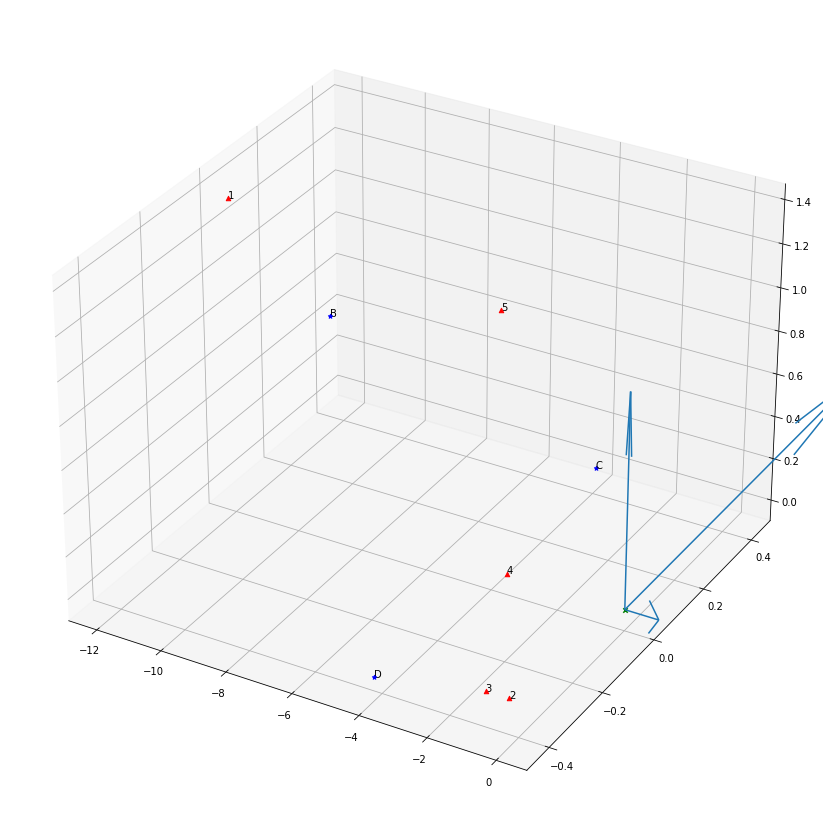

In [18]:
w = widgets.interactive(plot_mag, time=(df_sel_flight.index[0],df_sel_flight.index[-1],0.1), continuous_update=False) #If it show an error, just slide the time (it's due to removed sections)
display(w)

<font size="4">Interpretation of results :</font><br>
As we can seen above, there seems to be a convention problem betweeen vector magnetometers.